In [886]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from itertools import chain
from sklearn.preprocessing import StandardScaler

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping

# Neural Networks

In [887]:
# import bloom monthly data
bloom_monthly = pd.read_csv("bloom_monthly.csv")
bloom_monthly = bloom_monthly.drop(columns = "Unnamed: 0", axis = 1)
bloom_monthly.head()

,reservoir,yearmonth,m_avg_surf_temp,m_avg_deep_temp,m_avg_dissolved_oxygen,density_cells/ml,temperature,precipitation_sum,daylight_duration,type,stratification,latitude,longitude,alg_bloom,alg_bloom_num,temp_diff
0,BHR,198905,18.660000,12.935897,8.492308,0.0,15.983871,4.054839,51084.427742,Forest,Strong,37.3386,-83.4707,no bloom,0,5.724103
1,BHR,198906,24.787500,16.745000,7.085000,0.0,21.860000,6.020000,52900.719333,Forest,Strong,37.3386,-83.4707,no bloom,0,8.042500
2,BHR,198907,27.100000,20.720690,3.751724,0.0,23.796774,5.000000,51972.881613,Forest,Strong,37.3386,-83.4707,no bloom,0,6.379310
3,BHR,198908,26.840000,22.329730,0.800000,0.0,23.106452,3.619355,48790.638387,Forest,Strong,37.3386,-83.4707,no bloom,0,4.510270
4,BHR,198909,24.314286,22.703333,1.960000,0.0,19.916667,5.473333,44665.057333,Forest,Strong,37.3386,-83.4707,no bloom,0,1.610952


In [888]:
# encode type
le4 = LabelEncoder()
le4.fit(bloom_monthly['type'])
type_enc = le4.transform(bloom_monthly['type'])
type_labels = le4.classes_
bloom_monthly['type_enc'] = type_enc

# encode stratification
le4 = LabelEncoder()
le4.fit(bloom_monthly['stratification'])
strat_enc = le4.transform(bloom_monthly['stratification'])
strat_labels = le4.classes_
bloom_monthly['strat_enc'] = strat_enc

In [889]:
# create training and testing sets
y = bloom_monthly['alg_bloom_num'] # this is our class data
predictors = ['m_avg_deep_temp', 'm_avg_dissolved_oxygen', 'temperature', 'precipitation_sum', 'type_enc', 'strat_enc'] 
x = bloom_monthly[predictors] # predictor data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5) # complete a 70-30 split

In [890]:
x_train.to_csv('NN1_x_train.csv')
y_train.to_csv('NN1_y_train.csv')
x_test.to_csv('NN1_x_test.csv')
y_test.to_csv('NN1_y_test.csv')

## NN1

In [891]:
# build neural network model
mod = Sequential()
mod.add(Input((6,))) # Input tensor
mod.add(Dense(units=3, activation = 'relu')) # hidden layer 1
mod.add(Dense(units=1, activation = 'sigmoid')) #output layer 

# compile the model
mod.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
# run the model?
algae_nn = mod.fit(x_train,
                    y_train,
                    epochs=10, # you can set this to a big number!
                    batch_size=20,
                    shuffle=True,
                    verbose=1)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.2414 - loss: 1.3172
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.2469 - loss: 1.0800
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.2423 - loss: 0.9275
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.2961 - loss: 0.8181
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step - accuracy: 0.4080 - loss: 0.7422
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - accuracy: 0.5665 - loss: 0.6917
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - accuracy: 0.6571 - loss: 0.6681
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - accuracy: 0.7095 - loss: 0.6548
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - accuracy: 0.7270 - loss: 0.6459
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.7682 - loss: 0.6325


In [892]:
# predict using test data
y_pred = np.round(mod.predict(x_test),0)
y_pred = list(chain.from_iterable(y_pred))
# print accuracy and number of mislabelled values
print(f'Model accuracy score: {100*metrics.accuracy_score(y_test, y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test.shape[0], (y_test != y_pred).sum())) 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model accuracy score: 78.70%
Number of mislabeled points out of a total 230 points : 49


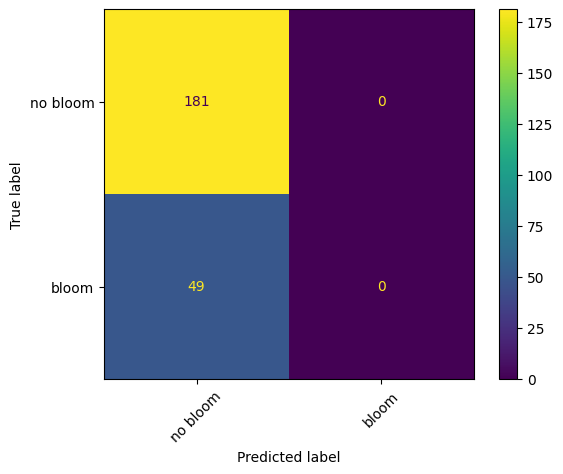

In [893]:
# create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['no bloom', 'bloom'])
disp.plot(xticks_rotation=45)

## NN2

In [894]:
def cat_numeric(list):
    spl_l = np.percentile(list, 50) # cut off bw low and med
    cat = [] # empty string to store values
    for i in range(len(list)):
        v = list[i]
        if v <= spl_l: # low algae bloom 
            cat.append(0)
        else: # high algae bloom
            cat.append(1)

    return cat

do_cat = cat_numeric(bloom_monthly['m_avg_dissolved_oxygen'])
bloom_monthly['do_cat'] = do_cat
bloom_monthly.head()

,reservoir,yearmonth,m_avg_surf_temp,m_avg_deep_temp,m_avg_dissolved_oxygen,density_cells/ml,temperature,precipitation_sum,daylight_duration,type,stratification,latitude,longitude,alg_bloom,alg_bloom_num,temp_diff,type_enc,strat_enc,do_cat
0,BHR,198905,18.660000,12.935897,8.492308,0.0,15.983871,4.054839,51084.427742,Forest,Strong,37.3386,-83.4707,no bloom,0,5.724103,1,0,1
1,BHR,198906,24.787500,16.745000,7.085000,0.0,21.860000,6.020000,52900.719333,Forest,Strong,37.3386,-83.4707,no bloom,0,8.042500,1,0,1
2,BHR,198907,27.100000,20.720690,3.751724,0.0,23.796774,5.000000,51972.881613,Forest,Strong,37.3386,-83.4707,no bloom,0,6.379310,1,0,1
3,BHR,198908,26.840000,22.329730,0.800000,0.0,23.106452,3.619355,48790.638387,Forest,Strong,37.3386,-83.4707,no bloom,0,4.510270,1,0,0
4,BHR,198909,24.314286,22.703333,1.960000,0.0,19.916667,5.473333,44665.057333,Forest,Strong,37.3386,-83.4707,no bloom,0,1.610952,1,0,1


In [895]:
bloom_monthly.to_csv('bloom_monthly_updated.csv')

In [925]:
# create training and testing sets
y = bloom_monthly['do_cat'] # this is our class data
predictors = ['temperature', 'precipitation_sum', 'density_cells/ml'] 
x = bloom_monthly[predictors] # predictor data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5) # complete a 70-30 split

In [926]:
x_train.to_csv('NN2_x_train.csv')
y_train.to_csv('NN2_y_train.csv')
x_test.to_csv('NN2_x_test.csv')
y_test.to_csv('NN2_y_test.csv')

In [1025]:
# build neural network model
mod = Sequential()
mod.add(Input((3,))) # Input tensor
mod.add(Dense(units=3, activation = 'relu')) # hidden layer 1
mod.add(Dense(units=1, activation = 'sigmoid')) #output layer 

# compile the model
mod.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
# run the model?
algae_nn = mod.fit(x_train,
                    y_train,
                    epochs=10, # you can set this to a big number!
                    batch_size=10,
                    shuffle=True,
                    verbose=1)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.5201 - loss: 91.7574
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.5314 - loss: 87.4190
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - accuracy: 0.5421 - loss: 45.9216
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - accuracy: 0.5997 - loss: 92.9198
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.6682 - loss: 48.0263
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.6714 - loss: 58.3378
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 0.6514 - loss: 77.8274
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - accuracy: 0.6589 - loss: 52.4194
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.6854 - loss: 38.9076
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.7072 - loss: 38.5802


In [1026]:
# predict using test data
y_pred = np.round(mod.predict(x_test),0)
y_pred = list(chain.from_iterable(y_pred))
# print accuracy and number of mislabelled values
print(f'Model accuracy score: {100*metrics.accuracy_score(y_test, y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test.shape[0], (y_test != y_pred).sum())) 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model accuracy score: 61.30%
Number of mislabeled points out of a total 230 points : 89


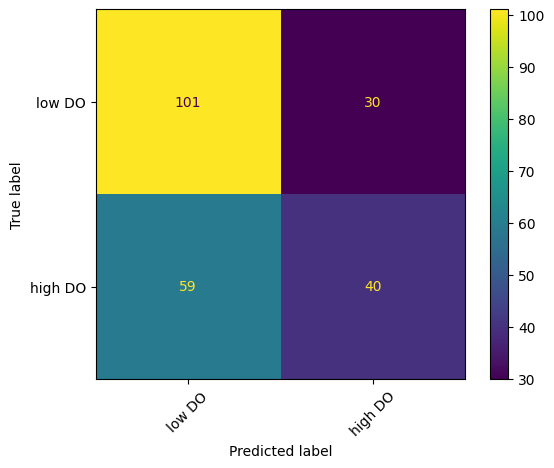

In [1027]:
# create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['low DO', 'high DO'])
disp.plot(xticks_rotation=45)

## Regression

### DO vs Temp

In [1077]:
temp_do = bloom_monthly[['temperature', 'm_avg_dissolved_oxygen']]
temp_do.to_csv('temp_do.csv')
temp_do.head()

,temperature,m_avg_dissolved_oxygen
0,15.983871,8.492308
1,21.860000,7.085000
2,23.796774,3.751724
3,23.106452,0.800000
4,19.916667,1.960000


In [1078]:
# create linear regression model
x = temp_do['temperature']
y = temp_do['m_avg_dissolved_oxygen']
slope, intercept, r, p, std_err = stats.linregress(x, y)

# get predicted values from regression model
def predict(x):
    return slope * x + intercept
y_hat = predict(temp_do['temperature'])

Text(30, 0, 'y = -0.32x + 9.27')

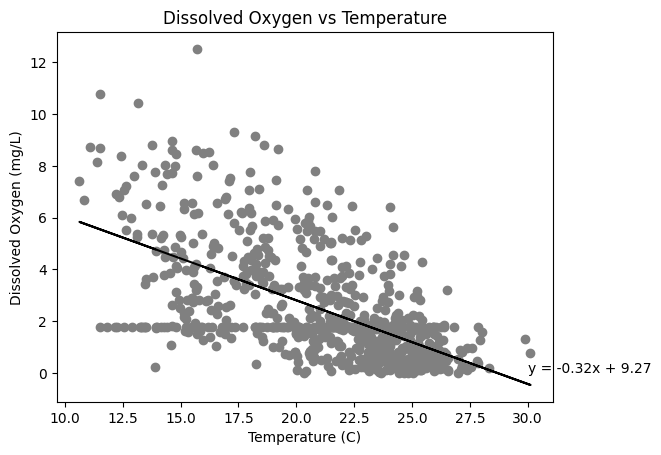

In [1079]:
# create a scatter plot of x and y
plt.scatter(x,y, c = 'grey')
# add the linear regression line
plt.plot(x, y_hat, c = 'black')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.xlabel('Temperature (C)')
plt.title('Dissolved Oxygen vs Temperature')
plt.annotate(text = 'y = -0.32x + 9.27', xy = (30, 0), xytext = (30, 0))

In [1080]:
print('Dissolved Oxygen = ', slope,'x Temperature +', intercept)
print('The coefficient of determination is', r*r)
print('The p-value is:', p)

Dissolved Oxygen =  -0.32327935050770923 x Temperature + 9.275201546002148
The coefficient of determination is 0.35660292882702826
The p-value is: 4.151390495456998e-75


### Surf Temp vs Temp

In [1081]:
temp_ST = bloom_monthly[['temperature', 'm_avg_surf_temp']]
temp_ST.to_csv('temp_ST.csv')
temp_ST.head()

,temperature,m_avg_surf_temp
0,15.983871,18.660000
1,21.860000,24.787500
2,23.796774,27.100000
3,23.106452,26.840000
4,19.916667,24.314286


In [1082]:
# create linear regression model
x = temp_ST['temperature']
y = temp_ST['m_avg_surf_temp']
slope, intercept, r, p, std_err = stats.linregress(x, y)

# get predicted values from regression model
def predict(x):
    return slope * x + intercept
y_hat = predict(temp_ST['temperature'])

Text(30, 31, 'y = 0.88x + 5.23')

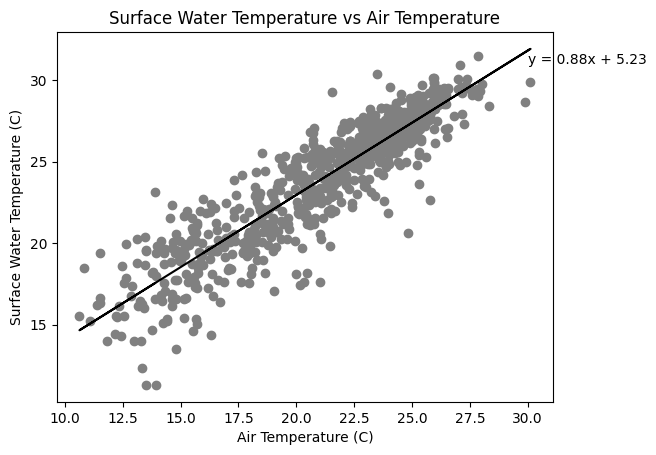

In [1083]:
# create a scatter plot of x and y
plt.scatter(x,y, c = 'grey')
# add the linear regression line
plt.plot(x, y_hat, c = 'black')
plt.ylabel('Surface Water Temperature (C)')
plt.xlabel('Air Temperature (C)')
plt.title('Surface Water Temperature vs Air Temperature')
plt.annotate(text = 'y = 0.88x + 5.23', xy = (30, 31), xytext = (30, 31))

In [1085]:
print('Surface Water Temperature = ', slope,'x Temperature +', intercept)
print('The coefficient of determination is', r*r)
print('The p-value is:', p)

Surface Water Temperature =  0.8863331311985452 x Temperature + 5.231906562579141
The coefficient of determination is 0.8183664433402613
The p-value is: 7.713348136964697e-285


### Deep Temp vs Temp

In [1086]:
temp_DT = bloom_monthly[['temperature', 'm_avg_deep_temp']]
temp_DT.to_csv("temp_DT.csv")
temp_DT.head()

,temperature,m_avg_deep_temp
0,15.983871,12.935897
1,21.860000,16.745000
2,23.796774,20.720690
3,23.106452,22.329730
4,19.916667,22.703333


In [1087]:
# create linear regression model
x = temp_DT['temperature']
y = temp_DT['m_avg_deep_temp']
slope, intercept, r, p, std_err = stats.linregress(x, y)

# get predicted values from regression model
def predict(x):
    return slope * x + intercept
y_hat = predict(temp_DT['temperature'])

Text(30, 22, 'y = 0.27x + 12.19')

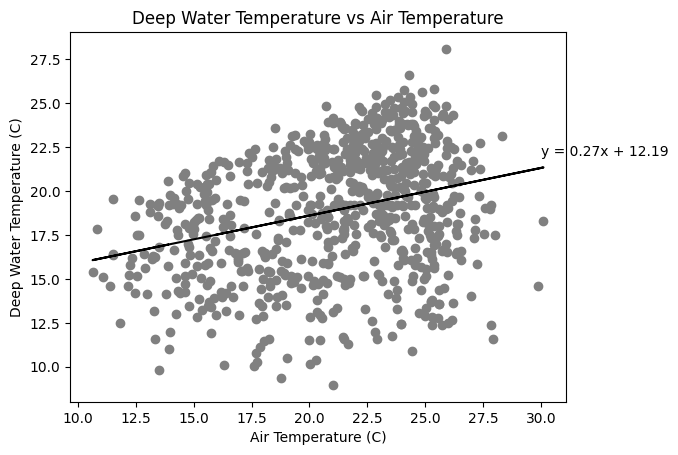

In [1088]:
# create a scatter plot of x and y
plt.scatter(x,y, c = 'grey')
# add the linear regression line
plt.plot(x, y_hat, c = 'black')
plt.ylabel('Deep Water Temperature (C)')
plt.xlabel('Air Temperature (C)')
plt.title('Deep Water Temperature vs Air Temperature')
plt.annotate(text = 'y = 0.27x + 12.19', xy = (30, 22), xytext = (30, 22))

In [1090]:
print('Deep Water Temperature = ', slope,'x Temperature +', intercept)
print('The coefficient of determination is', r*r)
print('The p-value is:', p)

Deep Water Temperature =  0.27099733561865663 x Temperature + 13.189672549865424
The coefficient of determination is 0.08893781734097082
The p-value is: 3.5312525367347517e-17
